# Example of how to use the Orca wrapper


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import logging

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import MolsToGridImage, MolToImage
from rdkit.Chem.MolStandardize import rdMolStandardize

In [4]:
try:
    import ppqm
except ModuleNotFoundError:
    import pathlib

    cwd = pathlib.Path().resolve().parent
    sys.path.append(str(cwd))
    import ppqm

In [5]:
from ppqm import orca
from ppqm import jupyter as ppqm_jupyter

Check that the correct orca executable is available in the environment

In [6]:
!which orca
!conda env list

/home/cloudlab/Library/orca/4.2.1-static_ompi-3.1.4/orca
# conda environments:
#
base                     /home/cloudlab/Library/miniconda3
default                  /home/cloudlab/Library/miniconda3/envs/default
ppqm                     /home/cloudlab/Library/miniconda3/envs/ppqm
research                 /home/cloudlab/Library/miniconda3/envs/research
                         /home/cloudlab/Repositories/apps/molcalc/env
                         /home/cloudlab/Repositories/python/molcalc/env
                      *  /home/cloudlab/Repositories/python/ppqm/env
                         /home/cloudlab/Repositories/python/tutorials/gtc2020-numba/env



## Set logging level

In [7]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger("ppqm").setLevel(logging.INFO)
logging.getLogger("orca").setLevel(logging.DEBUG)
show_progress = True

In [8]:
_logger = logging.getLogger(__name__)

## Define a molecule you like

### Methane

In [9]:
smiles = "C"
molobj = Chem.MolFromSmiles(smiles)

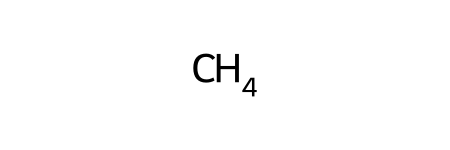

In [10]:
molobj

## Define an Orca calculator object

In [11]:
orca_options = {
    "scr": "./_tmp_directory_",  # Where should the calculations happen?
    "cmd": "orca",  # Where is the binary executable/command?
    "n_cores": 2,  # How many cores to use?
    "show_progress": True,  # Show progressbar during calculation
}

In [12]:
calc = orca.OrcaCalculator(**orca_options)
calc

OrcaCalc(cmd=/home/cloudlab/Library/orca/4.2.1-static_ompi-3.1.4/orca, scr=_tmp_directory_, n_cores=2, memory=2gb)

## Define what you would like to calculate

### Simple calculation on methane using semi-empirical method (PM3)

In [18]:
# Calculate values for molecule in water
calculation_option = {
    'NumFreq': None     # Compute numerical (vibrational) frequencies
}

In [19]:
# Generate conformers
molobj_conf = ppqm.tasks.generate_conformers(molobj, max_conformers=3)

In [20]:
molobj_conf.GetNumConformers()

1

In [21]:
# Calculate energy of conformers
results = calc.calculate(molobj_conf, calculation_option)

DEBUG:orca:start orca multiprocessing pool
INFO:orca:Using 2 core(s) per conformer
INFO:orca:1 conformer(s) in total on 2 cores
ORCA(1): 100%|████████████████████████████████████| 1/1 [00:44<00:00, 44.15s/it]


In [22]:
# The output type
print(type(results))
print(type(results[0]))
print(results[0].keys())

<class 'list'>
<class 'dict'>
dict_keys(['scf_energy', 'vibrational_frequencies', 'gibbs_free_energy', 'enthalpy', 'entropy', 'mulliken_charges', 'loewdin_charges', 'stationary_points', 'scf_converged', 'coord'])


In [23]:
# Collect all the orca energies
conformer_energies = [result["scf_energy"] for result in results]
conformer_energies

[-25205.32560044033]

In [24]:
# Find the lowest energy
idx = np.argmin(conformer_energies)
idx

0

### More complicated calculations on methane

#### Overview of selected Orca input file settings

**NumFreq**
  * Calculate vibrational modes using numerical calculation of Hessian

**B3LYP**

**def2-SVP**
  * An Ahlrichs def2 family double-zeta basis set
  * Recommended for DFT calculations on light main-group elements and 1st row TM elements (H-Kr)
  * Useful for initial geometry optimizations
  * Decent structures for organic/maingroup chemistry, but energies/properties shouldn't be trusted (with such small basis sets)

**D3BJ**
  * Add Grimme’s DFT-D3(BJ) dispersion correction method to DFT calc (free of charge)

**RIJCOSX**
  * Uses the RI-J approximation for Coulomb integrals (J)
  * Uses COSX numerical integration for HF exchange

**def2/J**
  * Weigend J auxiliary basis set (recommended in ORCA4)

**Grid4 and GridX4**
  * ORCA4-related DFT grid settings (supposedly better than default)
  * DFT grid stuff has been completely reworked in ORCA5 so these keywords won't work

**NMR**
  * Predict NMR spectra
  * Results are very conformer-dependent
  * Just typing NMR on 1st line w/o specifying the nuclei below will calc shieldings for all atoms
  * Specific atoms can be listed under the %EPRNMR block (should always come after the geometry section)
  * To request the NMR shieldings, just add {SHIFT} after the atom assignments

**def2/JK**
  * RI-JK approximation for Coulomb and HF Exchange for HF and hybrid-DFT methods (and for HF step in post-HF)

In [17]:
# Calculate values for molecule in water
calculation_option = {
    "NumFreq": None,    # Compute numerical (vibrational) frequencies
    "B3LYP": None,      #
    "def2-SVP": None,
    "D3BJ": None,
    "Hirshfeld": None,
    "RIJCOSX": None,    # Resolution of Identity (RI) method for faster calc
    "def2/J": None,
    "Grid4": None,
    "GridX4": None,
    "NMR": None,
    "def2/JK": None
}

In [18]:
# Generate conformers
molobj_conf = ppqm.tasks.generate_conformers(molobj, max_conformers=3)

In [19]:
molobj_conf.GetNumConformers()

1

In [20]:
# Calculate energy of conformers
results = calc.calculate(molobj_conf, calculation_option)

ORCA(1): 100%|████████████████████████████████████| 1/1 [01:26<00:00, 86.26s/it]


In [21]:
# The output type
print(type(results))
print(type(results[0]))
print(results[0].keys())

<class 'list'>
<class 'dict'>
dict_keys(['scf_energy', 'hirshfeld_charges', 'shielding_constants', 'vibrational_frequencies', 'gibbs_free_energy', 'enthalpy', 'entropy', 'mulliken_charges', 'loewdin_charges', 'stationary_points', 'scf_converged', 'coord'])


In [23]:
# Collect all the orca energies
conformer_energies = [result["scf_energy"] for result in results]
conformer_energies

[-25384.574309672127]

In [24]:
# Find the lowest energy
idx = np.argmin(conformer_energies)
idx

0

## Transfer the results into a Pandas dataframe

In [25]:
df = pd.DataFrame(results)
df

,scf_energy,hirshfeld_charges,shielding_constants,vibrational_frequencies,gibbs_free_energy,enthalpy,entropy,mulliken_charges,loewdin_charges,stationary_points,scf_converged,coord
0,-25384.57431,"[-0.103152, 0.026486, 0.026932, 0.02269, 0.027...","[190.453, 30.544, 30.673, 30.947, 30.614]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1318.31, 1340.3...",-25369.624741,-25354.857115,14.76762,"[-0.129302, 0.034204, 0.034221, 0.026239, 0.03...","[-0.114802, 0.029961, 0.028869, 0.026606, 0.02...",local_minimum,True,"[[0.0009055188548726867, 0.004071740571642823,..."


In [ ]:
# get coordinates for lowest energy conformer
coord = results[idx]["coord"]

In [ ]:
# get mulliken charges for lowest energy conformer
mulliken = results[idx]["mulliken_charges"]
mulliken

In [ ]:
# Copy only the graph of the molecule, keeping the atom order
molobj_prime = ppqm.chembridge.copy_molobj(molobj_conf)

# Get the coordinates of the best conformer
coord = results[idx]["coord"]

# Add conformer to molobj
ppqm.chembridge.molobj_add_conformer(molobj_prime, coord)

In [ ]:
ppqm_jupyter.show_molobj(molobj_prime)

In [ ]:
for coef, atom in zip(mulliken, molobj_prime.GetAtoms()):
    label = f"{coef:.2f}"
    atom.SetProp("atomNote", label)

In [ ]:
MolToImage(
    Chem.RemoveHs(molobj_prime),
    size=(300, 300),
)